In [ ]:
def is_uppercase(text):
    if any(char.isupper() for char in text):
        return True
    else:
        return False

False
True


In [14]:
#############################################
#          Preprocessing Definition         #
#############################################

import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split


# --------------------------
# Resizing and Padding Classes
# --------------------------

class ResizeWithPadding:
    """
    For color images. Uses bilinear interpolation.
    """
    def __init__(self, target_size=512, padding_mode='mean', force_resize=True, resize_dims=(128, 128)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims
        assert padding_mode in ['mean', 'reflect', 'hybrid'], \
            "Padding mode must be 'mean', 'reflect', or 'hybrid'"
        self.padding_mode = padding_mode

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        return resized_image

    def pad_image(self, image):
        h, w = image.shape[:2]
        # Determine target dimensions
        target_h, target_w = self.resize_dims if self.force_resize else (self.target_size, self.target_size)
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left

        if self.padding_mode == 'mean':
            mean_pixel = np.mean(image, axis=(0, 1), dtype=int)
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        elif self.padding_mode == 'reflect':
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
        else:  # hybrid
            reflected = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
            mean_pixel = np.mean(image, axis=(0, 1), dtype=int)
            padded_image = cv2.copyMakeBorder(reflected, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        return padded_image

    def __call__(self, img):
        # Convert PIL image to numpy array, process, and convert back
        arr = np.array(img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

class ResizeWithPaddingLabel:
    """
    For labels/masks. Uses nearest-neighbor interpolation.
    Assumes labels are single-channel images.
    """
    def __init__(self, target_size=512, force_resize=False, resize_dims=(256, 256)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        return resized_image

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = self.resize_dims if self.force_resize else (self.target_size, self.target_size)
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        # For labels, use a constant value (e.g., 0 for background)
        padded_image = cv2.copyMakeBorder(image, top, bottom, left, right,
                                          cv2.BORDER_CONSTANT, value=0)
        return padded_image

    def __call__(self, label_img):
        arr = np.array(label_img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

# --------------------------
# Augmentation Function for Synchronized Transforms
# --------------------------

def elastic_transform_pair(image, label, alpha=34, sigma=4):
    """Apply elastic transformation to both image and label."""
    np_img = np.array(image)
    np_label = np.array(label)
    random_state = np.random.RandomState(None)
    shape = np_img.shape[:2]
    dx = (random_state.rand(*shape) * 2 - 1)
    dy = (random_state.rand(*shape) * 2 - 1)
    dx = cv2.GaussianBlur(dx, (17, 17), sigma) * alpha
    dy = cv2.GaussianBlur(dy, (17, 17), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)
    transformed_img = cv2.remap(np_img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    transformed_label = cv2.remap(np_label, map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return Image.fromarray(transformed_img), Image.fromarray(transformed_label)

def augment_pair(image, label, size=(256, 256), apply_color=True, **params):
    """
    Applies a random subset of augmentations in random order.
    Each augmentation is stored as a function with its own probability.

    To disable an augmentation, set its probability to 0.
    To guarantee an augmentation, set its probability to 1.
    Modify parameters (e.g., rotation_angle, translate_factor) to adjust intensity.
    """
    # Build list of augmentation functions with their associated probability.
    augmentations = []

    # Horizontal flip
    augmentations.append((
        lambda img, lbl: (F.hflip(img), F.hflip(lbl)),
        params.get("flip_prob", 0.5)  # default: 50% chance
    ))

    # Rotation (you can control intensity via "rotation_angle")
    def rotate_aug(img, lbl):
        angle = random.uniform(-params.get("rotation_angle", 5), params.get("rotation_angle", 45))
        return F.rotate(img, angle, interpolation=Image.BILINEAR), F.rotate(lbl, angle, interpolation=Image.NEAREST)
    augmentations.append((
        rotate_aug,
        params.get("rotation_prob", 0.25)  # default: always apply rotation
    ))

    # Translation (intensity via "translate_factor")
    def translate_aug(img, lbl):
        max_translate = params.get("translate_factor", 0.05) * size[0]
        tx = int(random.uniform(-max_translate, max_translate))
        ty = int(random.uniform(-max_translate, max_translate))
        return (F.affine(img, angle=0, translate=(tx, ty), scale=1.0, shear=0, interpolation=Image.BILINEAR),
                F.affine(lbl, angle=0, translate=(tx, ty), scale=1.0, shear=0, interpolation=Image.NEAREST))
    augmentations.append((
        translate_aug,
        params.get("translate_prob", 0.05)  # default: always apply translation
    ))

    # Random Resized Crop (controls framing; intensity via crop_scale_range and crop_ratio_range)
    def crop_aug(img, lbl):
        i, j, h, w = transforms.RandomResizedCrop.get_params(
            img,
            scale=params.get("crop_scale_range", (0.9, 1.0)),
            ratio=params.get("crop_ratio_range", (1.0, 1.0))
        )
        return (F.resized_crop(img, i, j, h, w, size, interpolation=Image.BILINEAR),
                F.resized_crop(lbl, i, j, h, w, size, interpolation=Image.NEAREST))
    augmentations.append((
        crop_aug,
        params.get("crop_prob", 0.01)  # default: always apply crop
    ))

    # Elastic Transformation (intensity via "elastic_alpha" and "elastic_sigma")
    def elastic_aug(img, lbl):
        return elastic_transform_pair(
            img, lbl,
            alpha=params.get("elastic_alpha", 15),
            sigma=params.get("elastic_sigma", 2)
        )
    augmentations.append((
        elastic_aug,
        params.get("elastic_prob", 0.01)  # default: always apply elastic transformation
    ))

    # Random Scaling (intensity via "scaling_range")
    def scaling_aug(img, lbl):
        scale_factor = random.uniform(*params.get("scaling_range", (0.0, 0.0)))
        new_size = (int(size[0] * scale_factor), int(size[1] * scale_factor))
        return (F.resize(img, new_size, interpolation=Image.BILINEAR),
                F.resize(lbl, new_size, interpolation=Image.NEAREST))
    augmentations.append((
        scaling_aug,
        params.get("scaling_prob", 0.0)  # default: always apply scaling
    ))

    # Color augmentations: Gaussian blur and Color jitter.
    def color_aug(img, lbl):
        if random.random() < params.get("blur_prob", 0.0):
            img = img.filter(
                ImageFilter.GaussianBlur(
                    radius=random.uniform(*params.get("blur_radius_range", (0.5, 1.5)))
                )
            )
        color_jitter = transforms.ColorJitter(**params.get("color_jitter_params", {
            'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2, 'hue': 0.1
        }))
        img = color_jitter(img)
        return img, lbl
    augmentations.append((
        color_aug,
        params.get("color_prob", 0.25)  # default: always apply color adjustments if apply_color is True
    ))

    # Optionally randomize the order of augmentations.
    random.shuffle(augmentations)

    # Apply each augmentation based on its probability.
    for func, prob in augmentations:
        if random.random() < prob:
            image, label = func(image, label)

    # Optionally, enforce a final center crop to ensure the image is the desired size.
    image = F.center_crop(image, size)
    label = F.center_crop(label, size)

    return image, label

# --------------------------
# OOP Preprocessor Class
# --------------------------

class Preprocessor:
    def __init__(self, raw_color_path, raw_label_path,
                 proc_color_path, proc_label_path,
                 resize_dim=128, do_augmentation=True,
                 is_train=True, max_images=None, aug_count=10, aug_params=None):

        """
        Parameters:
          - raw_color_path: Relative path to raw color images.
          - raw_label_path: Relative path to raw label/mask images.
          - proc_color_path: Relative path to save processed color images.
          - proc_label_path: Relative path to save processed label images.
          - resize_dim: Target dimension for resizing/padding.
          - do_augmentation: Whether to augment (only for training).
          - is_train: True if processing training data.
          - max_images: Process only a subset of images (for testing the pipeline).
          - aug_count: Number of augmentations to create per image (train only).
        """
        self.aug_params = aug_params if aug_params is not None else {}

        self.raw_color_path = Path(raw_color_path)
        self.raw_label_path = Path(raw_label_path)
        self.proc_color_path = Path(proc_color_path)
        self.proc_label_path = Path(proc_label_path)
        self.resize_dim = resize_dim
        self.do_augmentation = do_augmentation and is_train
        self.is_train = is_train
        self.max_images = max_images
        self.aug_count = aug_count

        self.proc_color_path.mkdir(parents=True, exist_ok=True)
        self.proc_label_path.mkdir(parents=True, exist_ok=True)

        # Create transforms for images and labels
        self.transform_img = ResizeWithPadding(target_size=224, padding_mode='mean',
                                               force_resize=True, resize_dims=(resize_dim, resize_dim))
        self.transform_label = ResizeWithPaddingLabel(target_size=224, force_resize=True,
                                                      resize_dims=(resize_dim, resize_dim))

    def process(self):
        # Find all color images (assume image file names match label file names)
        image_extensions = (".jpg", ".jpeg", ".png")
        image_files = [f for f in self.raw_color_path.rglob("*") if f.suffix.lower() in image_extensions]
        if self.max_images is not None:
            image_files = image_files[:self.max_images]

        if not image_files:
            print("❌ No images found in", self.raw_color_path)
            return

        for img_file in image_files:
            label_file = self.raw_label_path / f"{img_file.stem}.png"
            if not label_file.exists():
                print(f"⚠️  Label for {img_file.name} not found, skipping.")
                continue

            # Open image and label (assume label is a segmentation mask in grayscale)
            img = Image.open(img_file).convert("RGB")
            label = Image.open(label_file).convert("L")

            # Apply resizing and padding to both image and label
            proc_img = self.transform_img(img)
            proc_label = self.transform_label(label)

            is_cat = is_uppercase(img_file.stem)

            # Save processed (base) image and label
            if is_cat:
                proc_img.save(self.proc_color_path / f"cat_{img_file.name}")
                proc_label.save(self.proc_label_path / f"cat_{label_file.name}")
                print(f"Processed {img_file.name}")
            else:
                proc_img.save(self.proc_color_path / f"dog_{img_file.name}")
                proc_label.save(self.proc_label_path / f"dog_{label_file.name}")
                print(f"Processed {img_file.name}")

            # If training and augmentation is enabled, create additional augmented pairs
            if self.is_train and self.do_augmentation:
                for i in range(self.aug_count):
                    aug_img, aug_label = augment_pair(proc_img, proc_label, size=(self.resize_dim, self.resize_dim), **self.aug_params)
                    if is_cat:
                        aug_img.save(self.proc_color_path / f"cat_{img_file.stem}_aug_{i}{img_file.suffix}")
                        aug_label.save(self.proc_label_path / f"cat_{label_file.stem}_aug_{i}{label_file.suffix}")
                        print(f"Augmented {img_file.name} -> aug {i}")
                    else:
                        aug_img.save(self.proc_color_path / f"dog_{img_file.stem}_aug_{i}{img_file.suffix}")
                        aug_label.save(self.proc_label_path / f"dog_{label_file.stem}_aug_{i}{label_file.suffix}")
                        print(f"Augmented {img_file.name} -> aug {i}")

# --------------------------
# Command Line Interface
# --------------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Preprocess train/test images with labels/masks using relative paths."
    )
    parser.add_argument("--raw_color", type=str, required=True, default='raw/TrainVal/color',
                        help="Relative path to raw color images (e.g., Dataset/raw/TrainVal/color).")
    parser.add_argument("--raw_label", type=str, required=True, default='raw/TrainVal/label',
                        help="Relative path to raw label images (e.g., Dataset/raw/TrainVal/label).")
    parser.add_argument("--proc_color", type=str, required=True, default='Dataset/processed/TrainVal/color',
                        help="Relative path to save processed color images (e.g., Dataset/processed/TrainVal/color).")
    parser.add_argument("--proc_label", type=str, required=True, default='Dataset/processed/TrainVal/label',
                        help="Relative path to save processed label images (e.g., Dataset/processed/TrainVal/label).")
    parser.add_argument("--resize_dim", type=int, default=128,
                        help="Output dimension for resizing (e.g., 128 or 256).")
    parser.add_argument("--no_augment", action="store_true",
                        help="Disable augmentation (for test sets).")
    parser.add_argument("--max_images", type=int, default=None,
                        help="Process only a subset of images (default: all).")
    parser.add_argument("--aug_count", type=int, default=10,
                        help="Number of augmentations per image (train only).")
    parser.add_argument("--set_type", type=str, choices=["TrainVal", "Test"], default="TrainVal",
                        help="Dataset type: TrainVal or Test.")
    parser.add_argument("--flip_prob", type=float, default=0.5, help="Probability for horizontal flip.")
    parser.add_argument("--rotation_angle", type=float, default=5, help="Maximum rotation angle (in degrees).")
    parser.add_argument("--translate_factor", type=float, default=0.05, help="Translation factor (fraction of image size).")
    parser.add_argument("--crop_scale_min", type=float, default=0.9, help="Minimum scale for random resized crop.")
    parser.add_argument("--crop_scale_max", type=float, default=1.0, help="Maximum scale for random resized crop.")
    parser.add_argument("--crop_ratio_min", type=float, default=1.0, help="Minimum aspect ratio for random resized crop.")
    parser.add_argument("--crop_ratio_max", type=float, default=1.0, help="Maximum aspect ratio for random resized crop.")
    parser.add_argument("--elastic_alpha", type=float, default=15, help="Elastic transformation alpha parameter.")
    parser.add_argument("--elastic_sigma", type=float, default=2, help="Elastic transformation sigma parameter.")
    parser.add_argument("--scaling_min", type=float, default=0.0, help="Minimum scaling factor for random scaling.")
    parser.add_argument("--scaling_max", type=float, default=0.0, help="Maximum scaling factor for random scaling.")
    parser.add_argument("--blur_prob", type=float, default=0.3, help="Probability of applying Gaussian blur.")
    parser.add_argument("--blur_radius_min", type=float, default=0.5, help="Minimum radius for Gaussian blur.")
    parser.add_argument("--blur_radius_max", type=float, default=1.5, help="Maximum radius for Gaussian blur.")
    parser.add_argument("--color_jitter_brightness", type=float, default=0.2, help="Brightness for color jitter.")
    parser.add_argument("--color_jitter_contrast", type=float, default=0.2, help="Contrast for color jitter.")
    parser.add_argument("--color_jitter_saturation", type=float, default=0.2, help="Saturation for color jitter.")
    parser.add_argument("--color_jitter_hue", type=float, default=0.1, help="Hue for color jitter.")

    ## Test processing (resizing)
    '''sys.argv = ['preprocessing.py', '--raw_color', './Datasetraw/Test/color',
                '--raw_label', './Dataset/raw/Test/label',
                '--proc_color', './Dataset/processed/Test/color',
                '--proc_label', './Dataset/processed/Test/label',
                '--resize_dim', '128',
                '--no_augment',
                '--set_type', 'Test']'''

    ## TrainVal augmentation
    sys.argv = ['preprocessing.py',
                '--raw_color', './Dataset/raw/TrainVal/color',
                '--raw_label', './Dataset/raw/TrainVal/label',
                '--proc_color', './Dataset/processed/TrainVal/color',
                '--proc_label', './Dataset/processed/TrainVal/label',
                '--resize_dim', '128',
                '--aug_count', '10',
                '--set_type', 'TrainVal',
                '--translate_factor', '0.02',
                '--elastic_alpha', '0.0',
                '--elastic_sigma', '0.05',
                '--blur_radius_min', '0.0',
                '--blur_radius_max', '0.05']

    args = parser.parse_args()

    # Define relative paths based on set type
    if args.set_type == "TrainVal":
        raw_color = Path("./Dataset/raw/TrainVal/color")
        raw_label = Path("./Dataset/raw/TrainVal/label")
        proc_color = Path("./Dataset/processed/TrainVal/color")
        proc_label = Path("./Dataset/processed/TrainVal/label")
    else:  # Test set
        raw_color = Path("./Dataset/raw/Test/color")
        raw_label = Path("./Dataset/raw/Test/label")
        proc_color = Path("./Dataset/processed/Test/color")
        proc_label = Path("./Dataset/processed/Test/label")

    aug_params = {
        "flip_prob": args.flip_prob,  # Already exists.
        "rotation_angle": args.rotation_angle,
        "rotation_prob": 0.25,         # Always apply rotation, for instance.
        "translate_factor": args.translate_factor,
        "translate_prob": 0.05,        # Always apply translation.
        "crop_scale_range": (args.crop_scale_min, args.crop_scale_max),
        "crop_ratio_range": (args.crop_ratio_min, args.crop_ratio_max),
        "crop_prob": 0.01,             # Always apply crop.
        "elastic_alpha": args.elastic_alpha,
        "elastic_sigma": args.elastic_sigma,
        "elastic_prob": 0.01,          # Always apply elastic transform.
        "scaling_range": (0.8, 1.2),
        "scaling_prob": 0.05,          # Always apply scaling.
        "blur_prob": args.blur_prob,
        "blur_radius_range": (args.blur_radius_min, args.blur_radius_max),
        "color_jitter_params": {
            "brightness": args.color_jitter_brightness,
            "contrast": args.color_jitter_contrast,
            "saturation": args.color_jitter_saturation,
            "hue": args.color_jitter_hue,
        },
        "color_prob": 1.0            # Always apply color adjustments if enabled.
    }

    preprocessor = Preprocessor(raw_color, raw_label,
                                proc_color, proc_label,
                                resize_dim=args.resize_dim,
                                do_augmentation=not args.no_augment,
                                is_train=(args.set_type == "TrainVal"),
                                max_images=args.max_images,
                                aug_count=args.aug_count,
                                aug_params=aug_params)

    preprocessor.process()

Processed basset_hound_112.jpg
Augmented basset_hound_112.jpg -> aug 0
Augmented basset_hound_112.jpg -> aug 1
Augmented basset_hound_112.jpg -> aug 2
Augmented basset_hound_112.jpg -> aug 3
Augmented basset_hound_112.jpg -> aug 4
Augmented basset_hound_112.jpg -> aug 5
Augmented basset_hound_112.jpg -> aug 6
Augmented basset_hound_112.jpg -> aug 7
Augmented basset_hound_112.jpg -> aug 8
Augmented basset_hound_112.jpg -> aug 9
Processed Siamese_193.jpg
Augmented Siamese_193.jpg -> aug 0
Augmented Siamese_193.jpg -> aug 1
Augmented Siamese_193.jpg -> aug 2
Augmented Siamese_193.jpg -> aug 3
Augmented Siamese_193.jpg -> aug 4
Augmented Siamese_193.jpg -> aug 5
Augmented Siamese_193.jpg -> aug 6
Augmented Siamese_193.jpg -> aug 7
Augmented Siamese_193.jpg -> aug 8
Augmented Siamese_193.jpg -> aug 9
Processed shiba_inu_122.jpg
Augmented shiba_inu_122.jpg -> aug 0
Augmented shiba_inu_122.jpg -> aug 1
Augmented shiba_inu_122.jpg -> aug 2
Augmented shiba_inu_122.jpg -> aug 3
Augmented shiba_i

In [12]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
from PIL import Image
from torchvision import transforms

class SegmentationDataset(Dataset):
    """
    A simple dataset for image segmentation.

    Assumes:
      - root_dir/color: contains the color (RGB) images.
      - root_dir/label: contains the corresponding label images.
      - Each label image has the same stem as its corresponding color image,
        and uses a .png extension.

    Optional transforms:
      - transform_img: transformation to apply to color images.
      - transform_label: transformation to apply to label images.

    Returns a tuple (image, label) where:
      - image is a Tensor of shape (C, H, W).
      - label is a Tensor of shape (H, W) containing integer class indices.
    """
    def __init__(self, root_dir, transform_img=None, transform_label=None):
        self.root_dir = Path(root_dir)
        self.color_dir = self.root_dir / "color"
        self.label_dir = self.root_dir / "label"
        self.transform_img = transform_img
        self.transform_label = transform_label

        # Gather all image files from the color directory.
        self.image_files = sorted([
            f for f in self.color_dir.iterdir()
            if f.is_file() and f.suffix.lower() in [".png", ".jpg", ".jpeg"]
        ])

        # print(f"Looking for images in {self.color_dir}")
        # print(f"Found {len(self.image_files)} images.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load color image.
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        # Build corresponding label path.
        label_path = self.label_dir / (img_path.stem + ".png")
        label = Image.open(label_path).convert("L")  # grayscale

        # print("Image path:", img_path)
        # print("Label path:", label_path)
        # print("Label file size:", label.size)
        raw_label = np.array(label, dtype=np.int64)
        # print("Unique values in raw label:", np.unique(raw_label))

        # Apply image transformation if provided; else default to ToTensor.
        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = transforms.ToTensor()(image)

        # Convert label to NumPy array.
        label_np = np.array(label, dtype=np.int64)

        # Correct mapping:
        #   0 remains 0,
        #   38 or 75 become 1,
        #   255 becomes 2.
        label_new = np.zeros_like(label_np)
        label_new[label_np == 38] = 1
        label_new[label_np == 75] = 1
        label_new[label_np == 255] = 2
        label_np = label_new

        # Convert mapped label to a torch tensor (of type long).
        label_tensor = torch.from_numpy(label_np).long()

        # Optionally apply label transform.
        if self.transform_label:
            label_tensor = self.transform_label(label_tensor)

        return image, label_tensor

In [13]:
#############################################
#             Patch-based dataset           #
#############################################

class PatchBasedDataset(Dataset):
    def __init__(self, root_dir, patch_size=128, transform_img=None, transform_label=None):
        """
        root_dir: Path to e.g. /content/processed/TrainVal
        patch_size: size of the patch to randomly crop
        transform_img: transformations to apply to the color image
        transform_label: transformations to apply to the label (optional)
        """
        self.base_dataset = SegmentationDataset(root_dir, transform_img, transform_label)
        self.patch_size = patch_size

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Retrieve the full image and mask from the base dataset
        image, mask = self.base_dataset[idx]  # image: (C, H, W), mask: (H, W)

        # Convert to PIL for random crop
        # but do NOT use transforms.ToTensor() on the mask again
        to_pil_img = transforms.ToPILImage()

        pil_image = to_pil_img(image)  # This will produce a PIL image in RGB
        # For the mask, ensure it's uint8 so that 0..255 remains intact
        pil_mask = Image.fromarray(mask.cpu().numpy().astype(np.uint8), mode="L")

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            pil_image, output_size=(self.patch_size, self.patch_size)
        )
        pil_image_patch = transforms.functional.crop(pil_image, i, j, h, w)
        pil_mask_patch = transforms.functional.crop(pil_mask, i, j, h, w)

        # Convert the cropped image back to a tensor (with normalization if needed)
        # e.g. transforms.ToTensor() or your transform_img pipeline
        # If your base_dataset already has transform_img, you can just do:
        image_patch = transforms.ToTensor()(pil_image_patch)

        # Convert the mask patch to a NumPy array to preserve integer classes
        mask_patch_np = np.array(pil_mask_patch, dtype=np.int64)

        # Convert to torch tensor of type long
        mask_patch = torch.from_numpy(mask_patch_np).long()

        return image_patch, mask_patch

In [14]:
#############################################
#           Debug utils Definition          #
#############################################

def visualize_samples(dataset, num_samples=3):
    """
    Prints and plots a few samples + labels from your dataset.
    """
    for i in range(num_samples):
        img, mask = dataset[i]  # Each dataset[i] = (img, mask)
        print(f"Sample {i} - Image shape: {img.shape}, Mask shape: {mask.shape}")
        fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].imshow(img.permute(1, 2, 0))
        ax[1].imshow(mask, cmap='gray')
        ax[0].set_title("Image")
        ax[1].set_title("Mask")
        plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    samples = []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            samples.append((images.cpu(), masks, preds))
            if len(samples) >= num_samples:
                break
    for idx, (img, mask, pred) in enumerate(samples):
        print(f"Predicted sample {idx}")
        fig, ax = plt.subplots(1, 3, figsize=(12,4))
        ax[0].imshow(img[0].permute(1,2,0))
        ax[1].imshow(mask[0], cmap='gray')
        ax[2].imshow(pred[0], cmap='gray')
        ax[0].set_title("Input Image")
        ax[1].set_title("Ground Truth")
        ax[2].set_title("Prediction")
        plt.show()

def compute_iou(preds, targets, num_classes):
    """
    Computes IoU for each class, and returns mean IoU.
    preds: [N, H, W] argmax predictions
    targets: [N, H, W] ground truth
    """
    ious = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        iou = intersection / (union + 1e-6)
        ious.append(iou.item())
    return sum(ious) / len(ious)

def get_weighted_ce_loss(dataset, num_classes):
    """
    Example of creating a class-weighted CrossEntropyLoss
    if you have an imbalanced dataset.
    """
    # Compute simple frequency-based weights (just an example)
    # Real usage: count the number of pixels per class across the dataset.
    # Here we use a placeholder uniform distribution
    class_counts = [100, 200, 300]  # example
    total = sum(class_counts)
    weights = [total / c for c in class_counts]
    weights_tensor = torch.tensor(weights, dtype=torch.float)
    return torch.nn.CrossEntropyLoss(weight=weights_tensor)

def compute_class_weights(dataset, num_classes=4):
    counts = [0] * num_classes
    for i in range(len(dataset)):
        _, mask = dataset[i]
        for cls in range(num_classes):
            counts[cls] += (mask == cls).sum().item()
    total = sum(counts)
    # Compute raw weights and normalize so mean==1
    raw_weights = [total / c if c > 0 else 0 for c in counts]
    weights_tensor = torch.tensor(raw_weights, dtype=torch.float)
    normalized_weights = weights_tensor / weights_tensor.mean()
    return normalized_weights

def adjust_learning_rate(optimizer, new_lr):
    """
    Set a new learning rate to see if predictions shift.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr


In [15]:
#############################################
#            Focal loss Definition          #
#############################################

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)  # pt is the probability of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [16]:
#############################################
#      evaluation_metrics.py Definition     #
#############################################

def compute_iou(pred, target, num_classes, smooth=1e-6):
    """
    Computes IoU for each class and returns a tensor of IoU values.
    Both pred and target should be torch tensors of shape [B, H, W] containing class indices.
    """
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            ious.append(float('nan'))  # No ground truth, IoU undefined.
        else:
            # Convert the tensor result to float before appending.
            value = ((intersection + smooth) / (union + smooth)).item()
            ious.append(value)
    return torch.tensor(ious, dtype=torch.float32)


In [18]:
import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split

# Enable cuDNN benchmark for fixed input sizes (e.g., 128x128)
torch.backends.cudnn.benchmark = True

#############################################
#          Improved Deep UNet Model         #
#           for 128x128 Images              #
#############################################

class DoubleConv(nn.Module):
    """
    Two consecutive conv layers, each with BatchNorm, Dropout2d and LeakyReLU activation.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.25):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """
    Downscaling with maxpool followed by a DoubleConv block.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.25):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_prob)
        )

    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    """
    Upscaling (using bilinear interpolation) then a DoubleConv block.
    """
    def __init__(self, x1_channels, x2_channels, out_channels, bilinear=True, dropout_prob=0.25):
        super(Up, self).__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(x1_channels, x1_channels, kernel_size=2, stride=2)
        total_in_channels = x1_channels + x2_channels
        self.conv = DoubleConv(total_in_channels, out_channels, dropout_prob)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """
    Final 1x1 convolution to map to the desired number of classes.
    """
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """
    Deep UNet for 128x128 input images with four downsampling steps.
    """
    def __init__(self, n_channels, n_classes, bilinear=True, base_channels=64, dropout_prob=0.25, apply_softmax=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.apply_softmax = apply_softmax

        self.inc   = DoubleConv(n_channels, base_channels, dropout_prob)
        self.down1 = Down(base_channels, base_channels * 2, dropout_prob)
        self.down2 = Down(base_channels * 2, base_channels * 4, dropout_prob)
        self.down3 = Down(base_channels * 4, base_channels * 8, dropout_prob)
        self.down4 = Down(base_channels * 8, base_channels * 16, dropout_prob)

        self.up1 = Up(x1_channels=base_channels * 16, x2_channels=base_channels * 8,
                      out_channels=(base_channels * 8) // 2, bilinear=bilinear, dropout_prob=dropout_prob)
        self.up2 = Up(x1_channels=(base_channels * 8) // 2, x2_channels=base_channels * 4,
                      out_channels=(base_channels * 4) // 2, bilinear=bilinear, dropout_prob=dropout_prob)
        self.up3 = Up(x1_channels=(base_channels * 4) // 2, x2_channels=base_channels * 2,
                      out_channels=(base_channels * 2) // 2, bilinear=bilinear, dropout_prob=dropout_prob)
        self.up4 = Up(x1_channels=(base_channels * 2) // 2, x2_channels=base_channels,
                      out_channels=base_channels, bilinear=bilinear, dropout_prob=dropout_prob)

        self.outc = OutConv(base_channels, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        if self.apply_softmax:
            return F.softmax(logits, dim=1)
        else:
            return logits

Distribution of mask classes:
  Masks with 3 classes [0,1,2]: 3694
  Masks with 2 classes [0,1]:   0
  Masks with 1 class:           16
Test Loss: 0.9902
Test IoU: 0.6283 (per class: [0.8554438416166491, 0.6700007737557756, 0.359586805525596])


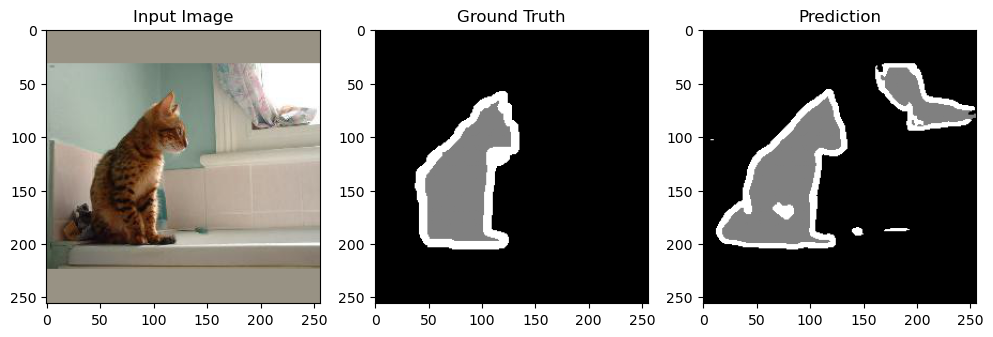

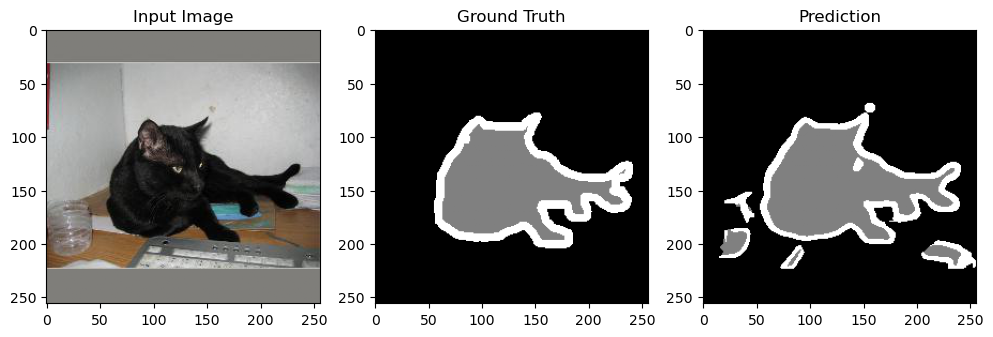

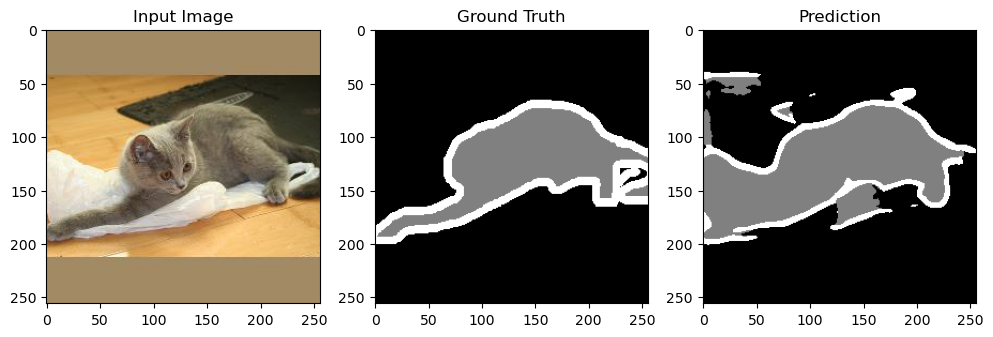

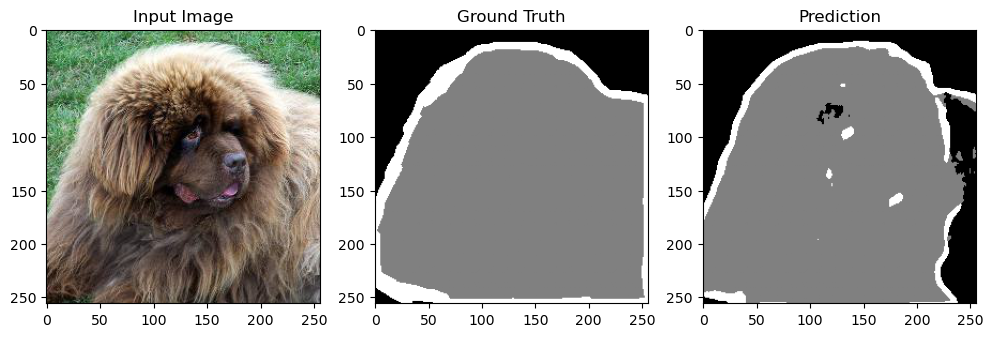

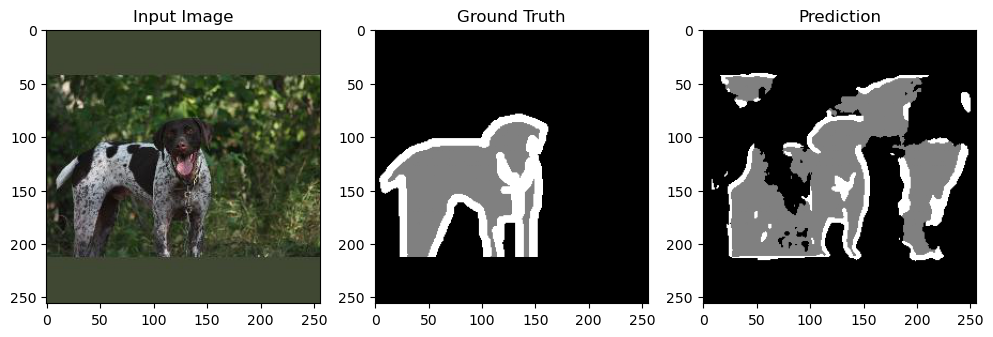

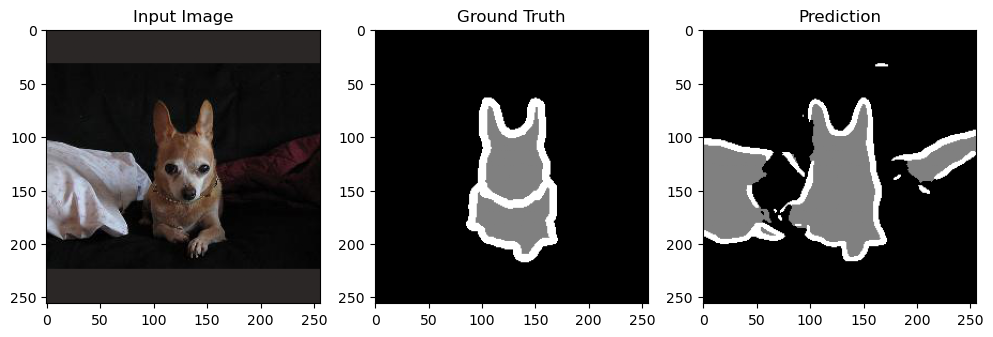

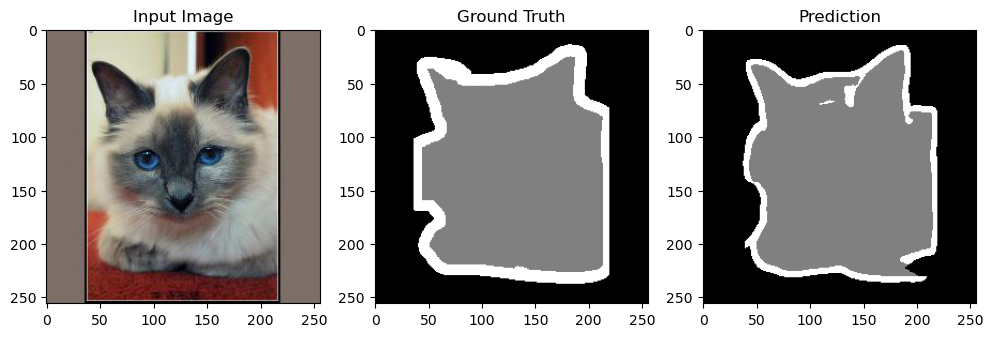

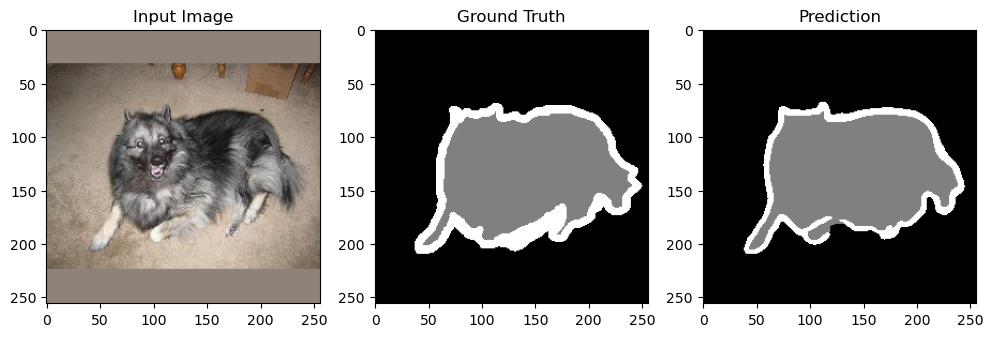

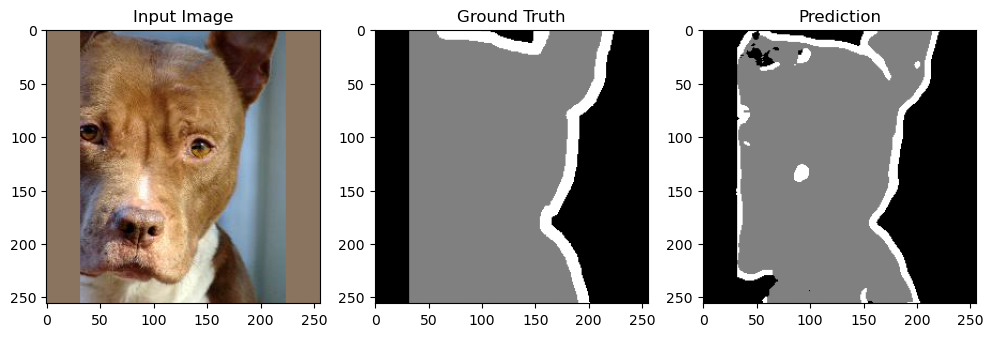

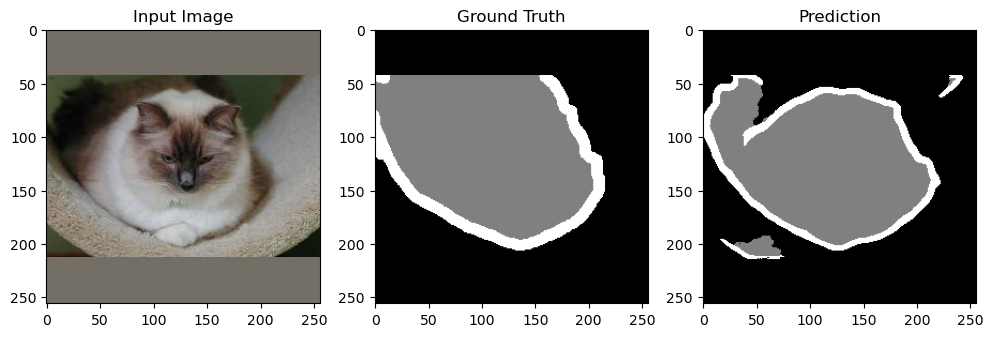

In [19]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random  # for random sampling

def compute_iou(preds, targets, num_classes=3):
    """
    Computes the Intersection-over-Union (IoU) for each class.

    Args:
      preds: Tensor of predicted class indices (N, H, W)
      targets: Tensor of ground truth class indices (N, H, W)
      num_classes: Number of classes

    Returns:
      A list with IoU for each class.
    """
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # or 0.0, depending on your preference
        else:
            ious.append(intersection / union)
    return ious

def test_model(model_path, test_dataset, batch_size=8, num_classes=3):
    device = torch.device("mps")

    # Instantiate and load the model.
    model = UNet(n_channels=3, n_classes=3).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # Use raw logits for loss computation.
    criterion = torch.nn.CrossEntropyLoss()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device).long()  # Ensure targets are long type

            # (Optional) Check target value range:
            if torch.min(targets) < 0 or torch.max(targets) >= num_classes:
                print(f"Target range error: min={torch.min(targets)}, max={torch.max(targets)}")

            outputs = model(images)  # raw logits
            loss = criterion(outputs, targets)
            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    avg_loss = total_loss / len(test_dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    print(f"Test Loss: {avg_loss:.4f}")

    # Compute IoU.
    ious = compute_iou(all_preds, all_targets, num_classes=num_classes)
    avg_iou = np.nanmean(ious)
    print(f"Test IoU: {avg_iou:.4f} (per class: {ious})")

    return avg_loss, all_preds, all_targets, model

def visualize_sample(dataset, model, device, idx=0):
    model.eval()
    img, mask = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).squeeze().cpu().numpy()
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.subplot(1,3,2)
    plt.imshow(mask_np, cmap='gray', vmin=0, vmax=2)
    plt.title("Ground Truth")
    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='gray', vmin=0, vmax=2)
    plt.title("Prediction")
    plt.show()

# --- Main block ---
if __name__ == "__main__":
    # Setup transforms for images and (optionally) for labels.
    transform_img = transforms.Compose([
        transforms.ToTensor(),
    ])
    transform_label = None  # Ensure your label transformation converts the mask to a tensor of type long

    # Replace with your actual test dataset directory.
    # For example, if your test images are in /content/processed/Test/color
    # and masks are in /content/processed/Test/label, adjust the SegmentationDataset accordingly.
    test_dataset = SegmentationDataset(
        root_dir="./Test",
        transform_img=transform_img,
        transform_label=transform_label
    )

    # Optional: check distribution of classes in the test set
    m3 = 0  # count of masks with three classes [0,1,2]
    m2 = 0  # count of masks with two classes [0,1]
    m1 = 0  # count of masks with only one class

    for i in range(len(test_dataset)):
        _, mask_sample = test_dataset[i]
        unique_vals = torch.unique(mask_sample).sort()[0]  # sort to ensure order is [0,1,2] if present
        # Compare against the expected tensors
        if torch.equal(unique_vals, torch.tensor([0, 1, 2])):
            m3 += 1
        elif torch.equal(unique_vals, torch.tensor([0, 1])):
            m2 += 1
        else:
            m1 += 1

    print(f"Distribution of mask classes:")
    print(f"  Masks with 3 classes [0,1,2]: {m3}")
    print(f"  Masks with 2 classes [0,1]:   {m2}")
    print(f"  Masks with 1 class:           {m1}")

    # Path to the saved model (state dictionary)
    model_path = "unet_best_v3.pth"

    # Run the test function. We also retrieve the trained model from here.
    avg_loss, preds, targets, model = test_model(model_path, test_dataset, batch_size=16)

    # Show 10 random samples from the dataset (input, ground truth, prediction).
    device = torch.device("mps")
    import random
    random_indices = random.sample(range(len(test_dataset)), 10)
    for idx in random_indices:
        visualize_sample(test_dataset, model, device, idx)